## Experiments for segmentation model used to identify poultry houses

### Terms/Vars

tile_1 = m_3807537_ne

Quadrangles / Regions / Set of tiles: 

poultry_region_1 = m_38075

poultry_region_2 = m_38076

poultry_region_3 = m_39075

non_poultry_region_1 = m_38077

non_poultry_region_2 = m_39077

### Setups

Model 1: Take 4000 random samples from tile_1, train on 2000 samples, test on 1000 samples and validate on 1000 samples.

Model 2: Train on 50000 random samples from poultry_region_1, test on poultry_region_2 and validate on poultry_region_3

##### Model_1 experiments

1.1. Using model_1, Test on entire tile_1 
    - Motivation: See how model performs, a starter

1.2. Using model_1, test on other random tiles. ("Other" tiles have poultry houses)
    - Motivation: See how model generalizes to tiles with poultry houses

1.3. Using model_1, Test on another tile without poultry house
    - Motivation: See how model generalizes to tiles without poultry houses

##### Model_2 experiments

- Motivation: See how model generalizes to tiles with/o poultry houses, and also to test experiment on larger scale

2.1. Train on 50000 random samples from poultry_region_1, test on poultry_region_2 and validate on poultry_region_3

2.2. Train on 50000 random samples from poultry_region_1,2,3, test on non_poultry_region_1,2.


### Neccessary functions
#### Get metrics

In [1]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import fiona
import matplotlib
import glob
import pandas as pd
from sklearn.metrics import jaccard_score

def get_metrics(pred_path, gt_path, non=False):
    src = rasterio.open(pred_path)
    raw = np.array(src.read())
    y_pred = (raw == 1) # chicken
    y_pred = y_pred.astype(int)
    y_pred = y_pred.squeeze()
    
    src_masked = rasterio.open(gt_path)
    y_true = np.array(src_masked.read())
    y_true = y_true.squeeze()
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    assert tp + tn + fp + fn == y_true.size

    n = tp + fp + tn + fn

    acc = (tp+tn)/n
    recall = (tp/(tp+fn))
    precision = tp / (tp + fp)
    iou = tp /(tp + fn + fp)
    
    if non == True:
        fpr = fp/(fp+tn)
        return iou, acc, precision, recall, fpr

#     print("IOU: {}".format(iou))
#     print("Accuracy: {}".format(acc))
#     print("Precision: {}".format(precision))
#     print("Recall: {}".format(recall))
    return iou, acc, precision, recall


Bad key "text.kerning_factor" on line 4 in
/home/jason/anaconda3/envs/ai4e/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
one_for_all = [
    "#FFFFFF",
    "#FF0000"
]
one_for_all_cmap = matplotlib.colors.ListedColormap(one_for_all)
plt.rcParams["figure.figsize"] = (20,10)
def plot_tile(path):
    src = rasterio.open(path)
    plt.imshow(src.read(1),vmin=0, vmax=2, cmap=one_for_all_cmap)
    plt.show()

In [3]:
def get_metrics_large(pred_path, mask_path):
    src = rasterio.open(pred_path)
    raw = np.array(src.read())
    y_pred = (raw == 1) # chicken
    y_pred = y_pred.astype(int)
    y_pred = y_pred.squeeze()
    
    src_masked = rasterio.open(mask_path)
    y_true = np.array(src_masked.read())
    y_true = y_true.squeeze()
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    assert tp + tn + fp + fn == y_true.size

    n = tp + fp + tn + fn

    acc = (tp+tn)/n
    recall = (tp/(tp+fn))
    precision = tp / (tp + fp)
    iou = tp /(tp + fn + fp)
    count = np.unique(y_true, return_counts=True)[1]
    pos = 0
    neg = 0
    if (len(count) == 1):
        neg = count[0]
    else:
        neg = count[0]
        pos = count[1]

    return iou, acc, precision, recall, pos, neg, tp, tn, fp, fn, src_masked.bounds

### Model 1

#### Data description

Here, samples = 150x150 patches

Ratio of chicken house to non-chicken house: 0.27
Number of chicken house patches: 1080
Train on 2009 samples, validate on 991 samples

Epoch 1: loss: 0.0624 - iou_coef: 0.9398 - val_loss: 0.0322 - val_iou_coef: 0.9667
Epoch 2: loss: 0.0330 - iou_coef: 0.9656 - val_loss: 0.0317 - val_iou_coef: 0.9662
Epoch 3: loss: 0.0297 - iou_coef: 0.9687 - val_loss: 0.0325 - val_iou_coef: 0.9651
Epoch 4: loss: 0.0265 - iou_coef: 0.9717 - val_loss: 0.0257 - val_iou_coef: 0.9716

Early stopped

Test results on 1000 samples

loss: 0.027708684034645558, iou_coef: 0.9688617587089539

### Experiment 1.1

Using model_1, Test on entire tile_1 

In [4]:
metrics = {}
all_metrics = []

In [75]:
exps = glob.glob('../landcover_scripts/test_run/single_tile_4000s_inf/*')
for e in exps:
    temp = {}
    temp['model'] = e.split("/")[-1]
    temp_metrics = [*get_metrics(e,"./m_3807537_ne_18_1_20170611_rasterized2.tif")]
    temp['iou'] = temp_metrics[0]
    temp['acc'] = temp_metrics[1]
    temp['precision'] = temp_metrics[2]
    temp['recall'] = temp_metrics[3]
    all_metrics.append(temp)

In [76]:
pd.DataFrame(all_metrics)

,model,iou,acc,precision,recall
0,ae_tuned_model_02_single_inference.tif,0.704366,0.997044,0.733813,0.946100
1,ae_tuned_model_04_single_inference.tif,0.781518,0.998095,0.842289,0.915482
2,ae_tuned_model_03_single_inference.tif,0.747645,0.997860,0.859290,0.851947
3,ae_tuned_model_01_single_inference.tif,0.733203,0.997613,0.813599,0.881235


#### Visualization

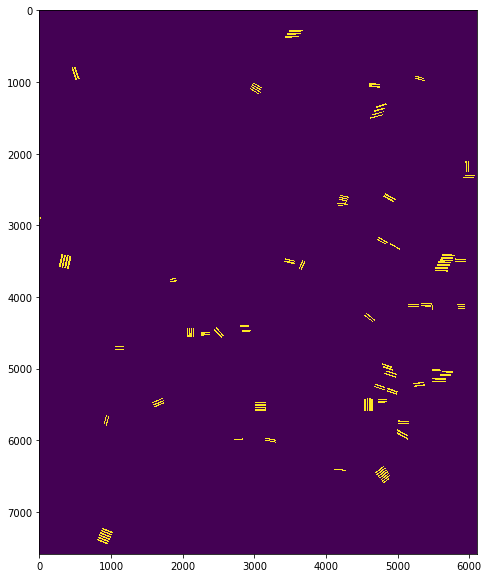

In [87]:
# Ground truth
plt.imshow(rasterio.open("./m_3807537_ne_18_1_20170611_rasterized2.tif").read(1))

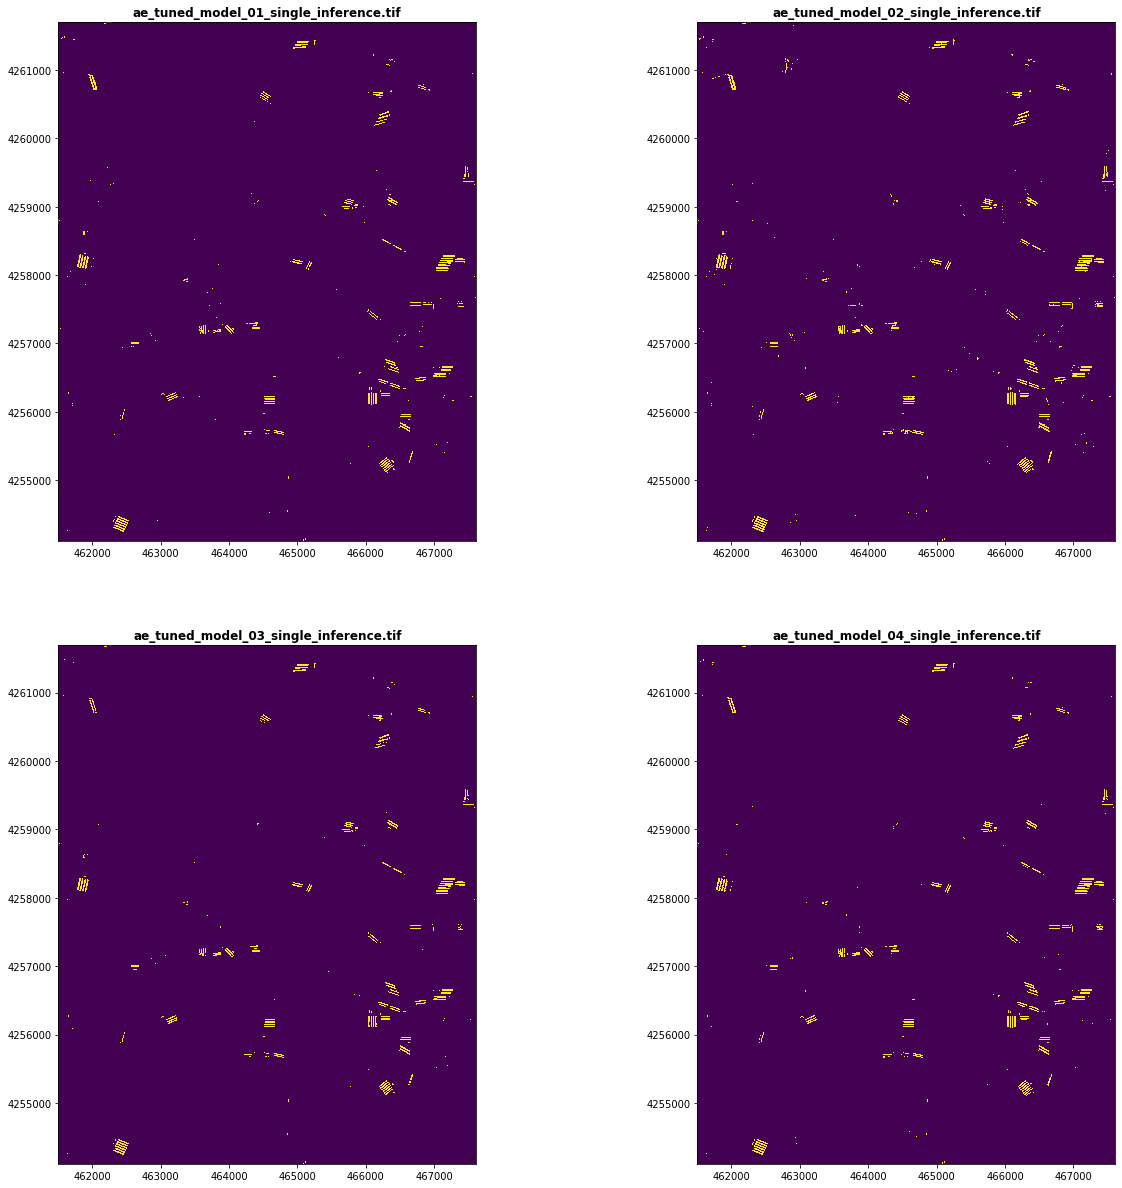

In [77]:
src1 = rasterio.open(exps[0])
src2 = rasterio.open(exps[1])
src3 = rasterio.open(exps[2])
src4 = rasterio.open(exps[3])
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2,2, figsize=(21,21))
show((src1, 1), ax=ax2, title=exps[0].split("/")[-1])
show((src2, 1), ax=ax4, title=exps[1].split("/")[-1])
show((src3, 1), ax=ax3, title=exps[2].split("/")[-1])
show((src4, 1), ax=ax1, title=exps[3].split("/")[-1])

### Experiment 1.2

Using model_1, test on other random tiles. ("Other" tiles have poultry houses)

Tile tested: "../../../media/disk2/datasets/all_maryalnd_naip/m_3807536_se_18_1_20170611.mrf"

In [80]:
metrics = {}
all_metrics = []

exps = glob.glob('../landcover_scripts/test_run/single_tile_4000s_inf_2/*')
for e in exps:
    temp = {}
    temp['model'] = e.split("/")[-1]
    temp_metrics = [*get_metrics(e,"../landcover_scripts/binary_raster_md_tif/m_3807536_se_18_1_20170611_inference_rasterized.tif")]
    temp['iou'] = temp_metrics[0]
    temp['acc'] = temp_metrics[1]
    temp['precision'] = temp_metrics[2]
    temp['recall'] = temp_metrics[3]
    all_metrics.append(temp)

In [81]:
pd.DataFrame(all_metrics)

,model,iou,acc,precision,recall
0,ae_tuned_model_02_single_inference.tif,0.191177,0.990934,0.195846,0.889123
1,ae_tuned_model_04_single_inference.tif,0.293950,0.995354,0.316862,0.802573
2,ae_tuned_model_03_single_inference.tif,0.409455,0.997547,0.493794,0.705649
3,ae_tuned_model_01_single_inference.tif,0.259189,0.994439,0.276280,0.807313


### Visualization

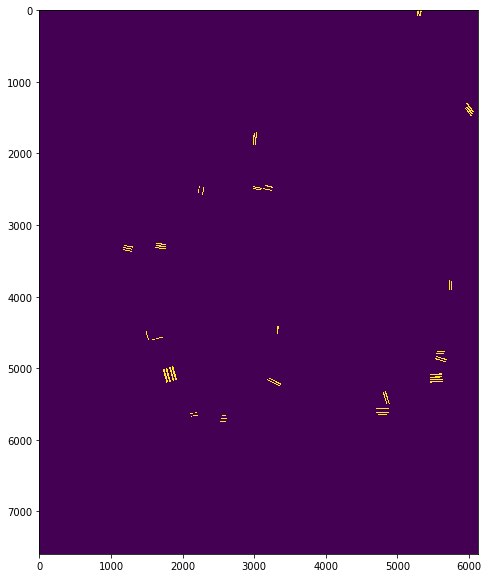

In [88]:
# Ground truth
plt.imshow(rasterio.open("../landcover_scripts/binary_raster_md_tif/m_3807536_se_18_1_20170611_inference_rasterized.tif").read(1))

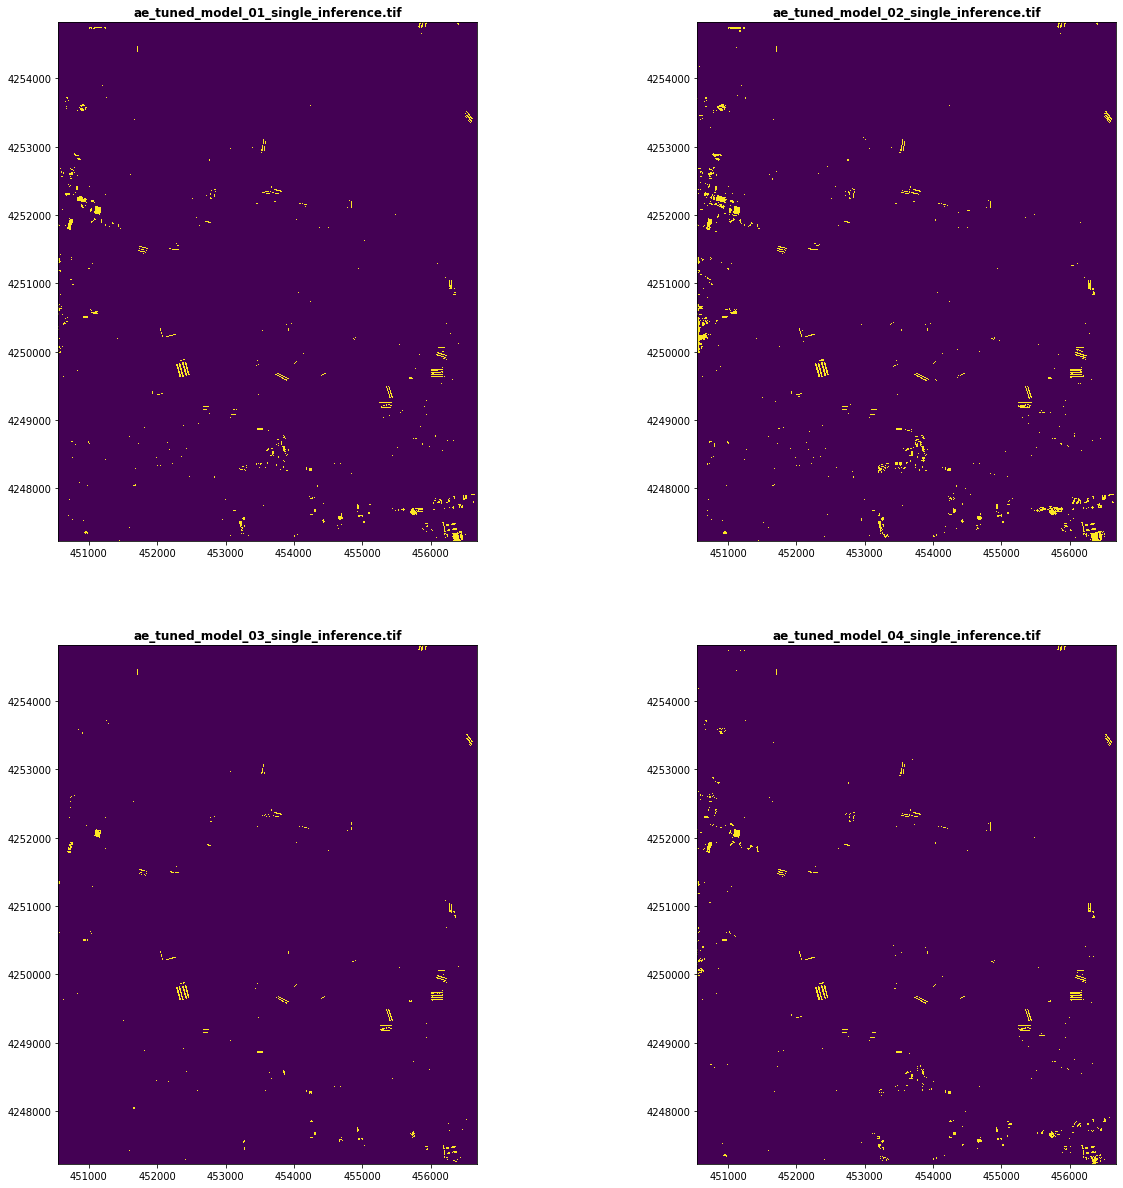

In [82]:
src1 = rasterio.open(exps[0])
src2 = rasterio.open(exps[1])
src3 = rasterio.open(exps[2])
src4 = rasterio.open(exps[3])
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2,2, figsize=(21,21))
show((src1, 1), ax=ax2, title=exps[0].split("/")[-1])
show((src2, 1), ax=ax4, title=exps[1].split("/")[-1])
show((src3, 1), ax=ax3, title=exps[2].split("/")[-1])
show((src4, 1), ax=ax1, title=exps[3].split("/")[-1])

### Experiment 1.3. 

Using model_1, Test on another tile without poultry house

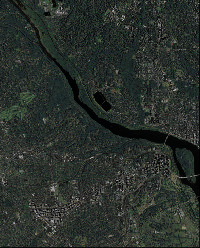

In [96]:
from IPython.display import Image
Image(filename='../../../media/disk2/datasets/all_maryalnd_naip/m_3807708_sw_18_1_20170716.200.jpg') 

### Visualization

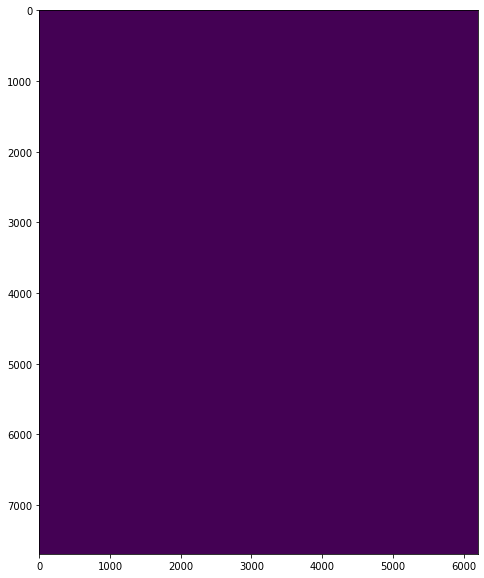

In [95]:
plt.imshow(rasterio.open("../landcover_scripts/binary_raster_md_tif/m_3807708_sw_18_1_20170716_inference_rasterized.tif").read(1))

### Metrics

In [102]:
metrics = {}
all_metrics = []

exps = glob.glob('../landcover_scripts/test_run/single_tile_4000s_inf_3/*')
for e in exps:
    temp = {}
    temp['model'] = e.split("/")[-1]
    temp_metrics = [*get_metrics(e,"../landcover_scripts/binary_raster_md_tif/m_3807708_sw_18_1_20170716_inference_rasterized.tif", True)]
    temp['iou'] = temp_metrics[0]
    temp['acc'] = temp_metrics[1]
    temp['precision'] = temp_metrics[2]
    temp['recall'] = temp_metrics[3]
    temp['fpr'] = temp_metrics[4]
    all_metrics.append(temp)

/home/jason/anaconda3/envs/ai4e/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


In [104]:
pd.DataFrame(all_metrics)

,model,iou,acc,precision,recall,fpr
0,ae_tuned_model_02_single_inference.tif,0.0,0.974751,0.0,NaN,0.025249
1,ae_tuned_model_04_single_inference.tif,0.0,0.989942,0.0,NaN,0.010058
2,ae_tuned_model_03_single_inference.tif,0.0,0.997911,0.0,NaN,0.002089
3,ae_tuned_model_01_single_inference.tif,0.0,0.986573,0.0,NaN,0.013427


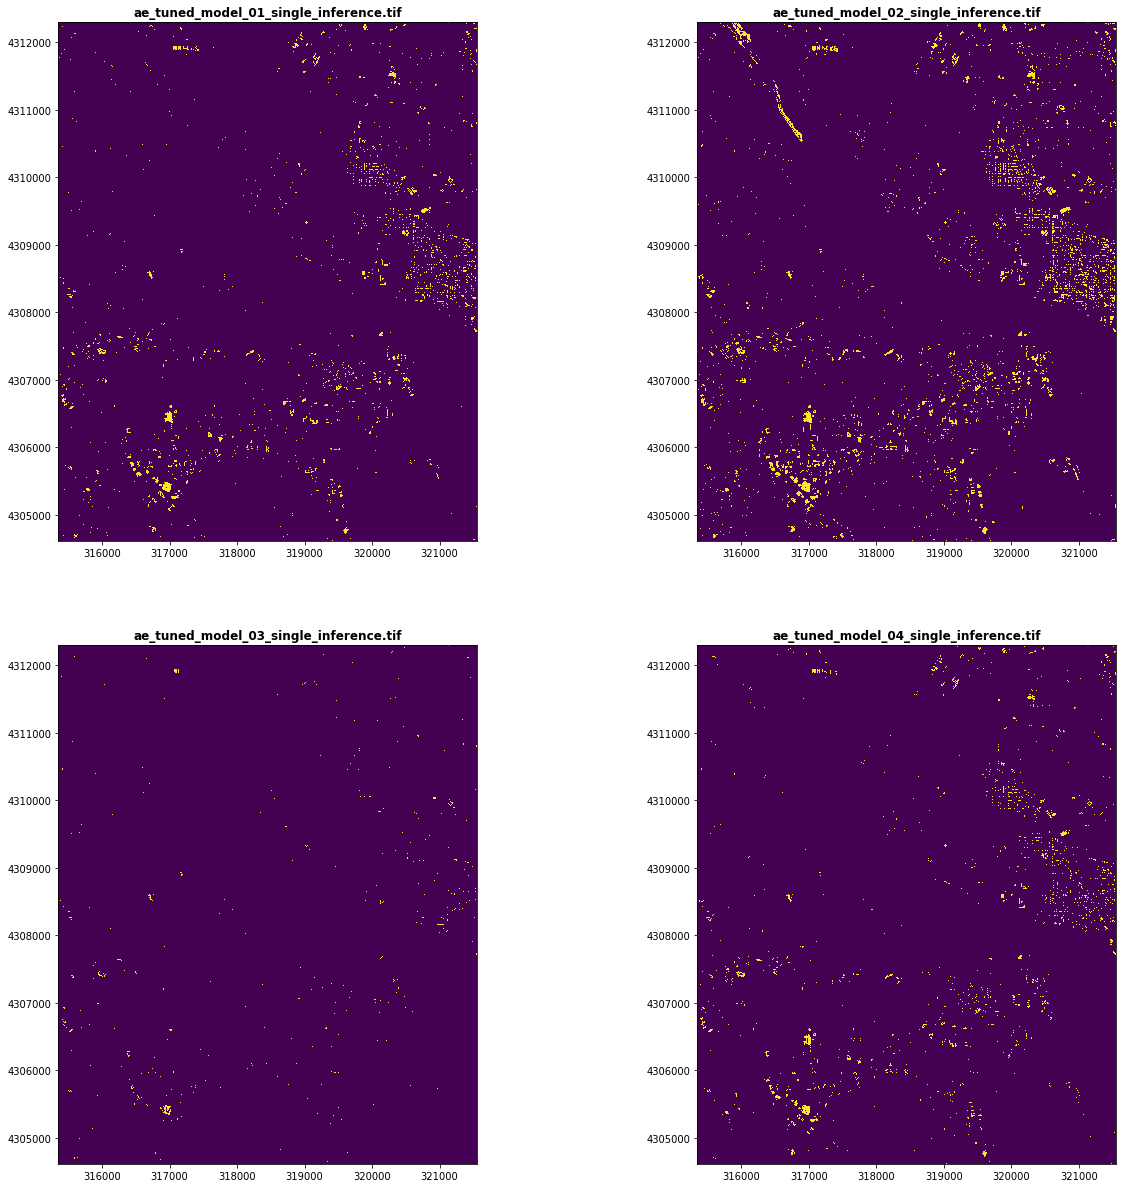

In [100]:
src1 = rasterio.open(exps[0])
src2 = rasterio.open(exps[1])
src3 = rasterio.open(exps[2])
src4 = rasterio.open(exps[3])
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2,2, figsize=(21,21))
show((src1, 1), ax=ax2, title=exps[0].split("/")[-1])
show((src2, 1), ax=ax4, title=exps[1].split("/")[-1])
show((src3, 1), ax=ax3, title=exps[2].split("/")[-1])
show((src4, 1), ax=ax1, title=exps[3].split("/")[-1])

## Model 2

#### Data description

Here, samples = 150x150 patches

(50000, 150, 150, 2) - 50000 random patches shaped 150x150x2 extracted from poultry_region_1

Ratio of chicken house to non-chicken: 0.38872

Number of chicken house patches amongst the 50000 patches: 19436


> Model trained at epoch 4 was used

### Experiment 2.1 

Train on 50000 random samples from poultry_region_1, test on poultry_region_2 and validate on poultry_region_3

In [14]:
all_fns = glob.glob('../landcover_scripts/test_run/multi_tile_50000s_reg_1/*')

In [15]:
all_metrics = []
count = 0
for fn in all_fns:
    if count % 5 == 0:
        print(count)
    count+=1
    test_filename = "../landcover_scripts/binary_raster_md_tif/" + (fn.split("/")[4].split(".")[0][:-16]) + "_inference_rasterized.tif"
    temp = {}
    temp['name'] = (fn.split("/")[3].split(".")[0][:-10])
    temp_metrics = get_metrics_large(test_filename, fn)
    temp['iou'] = temp_metrics[0]
    temp['acc'] = temp_metrics[1]
    temp['precision'] = temp_metrics[2]
    temp['recall'] = temp_metrics[3]
    temp['pos'] = temp_metrics[4]
    temp['neg'] = temp_metrics[5]
    temp['tp'] = temp_metrics[6]
    temp['tn'] = temp_metrics[7]
    temp['fp'] = temp_metrics[8]
    temp['fn'] = temp_metrics[9]
    temp['xmin'] = temp_metrics[10].left
    temp['xmax'] = temp_metrics[10].right
    temp['ymin'] = temp_metrics[10].bottom
    temp['ymax'] = temp_metrics[10].top
    all_metrics.append(temp)

0


/home/jason/anaconda3/envs/ai4e/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars


5
10
15
20
25
30
35
40


/home/jason/anaconda3/envs/ai4e/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
/home/jason/anaconda3/envs/ai4e/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140


In [16]:
df = pd.DataFrame(all_metrics)
df.head()

,name,iou,acc,precision,recall,pos,neg,tp,tn,fp,fn,xmin,xmax,ymin,ymax
0,multi_tile_50,0.432383,0.999563,0.711256,0.524438,29544,46502980,15494,46496690,6290,14050,455900.0,462034.0,4226396.0,4233982.0
1,multi_tile_50,0.343516,0.998825,0.728261,0.394021,72118,46159578,28416,46148975,10603,43702,477830.0,483934.0,4240190.0,4247764.0
2,multi_tile_50,0.327501,0.999717,0.862328,0.345570,18633,46715551,6439,46714523,1028,12194,428654.0,434800.0,4240442.0,4248046.0
3,multi_tile_50,0.082263,0.995439,0.617138,0.086687,218672,46150520,18956,46138760,11760,199716,434684.0,440782.0,4309754.0,4317358.0
4,multi_tile_50,0.000000,0.836441,NaN,0.000000,7685745,39304975,0,39304975,0,7685745,417584.0,423754.0,4226666.0,4234282.0


In [17]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [18]:
df.mean()

iou                0.30870
acc                0.98173
precision          0.75577
recall             0.34825
pos           894309.83448
neg         45692881.11724
tp             47487.53103
tn          45681753.77241
fp             11127.34483
fn            846822.30345
xmin          442735.13103
xmax          448866.64828
ymin         4244628.59310
ymax         4252226.55172
dtype: float64

In [19]:
df.sum()

name         multi_tile_50multi_tile_50multi_tile_50multi_t...
iou                                                   44.45297
acc                                                  142.35072
precision                                             87.66956
recall                                                50.14848
pos                                                  129674926
neg                                                 6625467762
tp                                                     6885692
tn                                                  6623854297
fp                                                     1613465
fn                                                   122789234
xmin                                            64196594.00000
xmax                                            65085664.00000
ymin                                           615471146.00000
ymax                                           616572850.00000
dtype: object

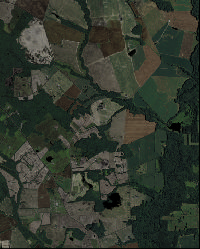

In [20]:
from IPython.display import Image
Image(filename='../../../media/disk2/datasets/all_maryalnd_naip/m_3807501_nw_18_1_20170609.200.jpg')

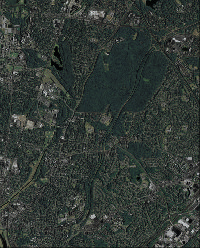

In [22]:
Image(filename='../../../media/disk2/datasets/all_maryalnd_naip/m_3807601_ne_18_1_20170716.200.jpg')